In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap
from sklearn.decomposition import PCA


pd.set_option('display.max_columns', 40)
plt.rcParams['figure.figsize'] = 12,7
plt.rcParams['figure.dpi'] = 100


df: pd.DataFrame = pd.read_csv("Life Expectancy Data.csv")


# Formatting DataFrame for further analysis
stripped_columns = []

for col_num, col_name in enumerate(df.columns):
    stripped_columns.append(col_name.strip(' '))
    
df.columns = stripped_columns

# Fail safe DataFrame in case we duck up something
df_copy = df.copy()
df = df.sort_values(by=['Country', 'Year'])
df = df.reset_index(drop=True)

df_wo_null_values = df.copy()
df_wo_null_values = df_wo_null_values.dropna()
df_wo_null_values = df_wo_null_values.reset_index(drop=True)


**<h4>**Handling outliers**<h4>**

In [3]:
for column in df_wo_null_values.columns[4:]:

    descriptive_stats = df_wo_null_values[column].describe()


    median = descriptive_stats['50%']
    Q1 = descriptive_stats['25%']
    Q3 = descriptive_stats['75%']
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    IQR_range = (lower_bound, upper_bound)

    upper_outliers_boolean_indexing = df_wo_null_values[column] > upper_bound
    lower_outliers_boolean_indexing = df_wo_null_values[column] < lower_bound

    combined_boolean_indexing = (upper_outliers_boolean_indexing | lower_outliers_boolean_indexing)

    df_wo_null_values[column] = df_wo_null_values[column].mask(
        cond = combined_boolean_indexing,
        other = median
    )
    



**<h1>**As the data represents a bunch of time serieses across different countries it is reasonable to assume that we might better split this task into 2:**</h1>**

**<h3>**1. Regression anaylysis for each year<br>2. Multivariate time series analysis for each country**</h3>**


**<h5>**It is also reasonable to do the regression analysis for each year as the bare minimum condition of having atleast 5-6 training example per feature is satisfied**</h5>**


In [4]:
regression_df = df.copy()
regression_df = regression_df.sort_values(by='Year')
regression_df = regression_df.reset_index(drop=True)

regression_df['Status'] = regression_df['Status'].replace({
    "Developed": 1,
    "Developing": 0,
})


C:\Users\user\AppData\Local\Temp\ipykernel_14984\1529690317.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  regression_df['Status'] = regression_df['Status'].replace({


**<h2>**Handling missing data**</h2>**
**<h4>**For every column that contains NULL values we look for the indexes of missing values in order to understand the nature of the absence**<h4>**

**<h4>**That's an experimental method to fill in NA values, so I don't really count on its theorethical foundation**<h4>**

In [ ]:
from numpy.linalg import norm
from numpy import dot 



# Define cosine similarity function
def cosine_similarity(a: tuple | list,b: tuple | list) -> np.float64:

    return dot(a,b) / (norm(a) * norm(b))


# Leaving only rows with NULL values in DataFrame 
non_null_indexes = df_copy.dropna().index
null_indexes = []

for index in df_copy.index:
    if index not in non_null_indexes:
        null_indexes.append(index)

df_with_null_values = df_copy.copy()
df_with_null_values = df_with_null_values.iloc[null_indexes, :]
df_with_null_values = df_with_null_values.reset_index(drop=True)


# Calculate similiarities between rows with NULL values and all the other rows without NULL values
top_similaries_for_null_rows = {}

for row_num, row in df_with_null_values.iterrows():

    columns_with_null_values = row[row.isnull()].index

    feature_vector = tuple(row.fillna(0).values)[3:]

    similarities = []

    for row_num_2, row_2 in df_wo_null_values.iterrows():

        feature_vector_2 = row_2.copy()
        feature_vector_2[columns_with_null_values] = 0
        feature_vector_2 = tuple(feature_vector_2.values)[3:]

        similarity = cosine_similarity(feature_vector, feature_vector_2)

        row_similarity = {row_num_2: similarity}
        similarities.append(row_similarity)
    

    
    top_similaries_for_null_rows[row_num] = similarities
    series = top_similaries_for_null_rows[row_num].apply(lambda x: list(x.values())[0])
    most_similar_rows = series.sort_values(ascending=False)[:100]
    most_similar_rows_indexes = most_similar_rows.index

    median_values = df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values].median()
    mad = (df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values] - df_wo_null_values.loc[most_similar_rows_indexes, columns_with_null_values].mean()).abs().mean() 
    normally_distributed_value = np.random.normal(loc=0, scale=1, size=1)[0]

    values_to_fill = median_values + mad * normally_distributed_value
    df_with_null_values.loc[row_num, columns_with_null_values] = values_to_fill

    

    
    



In [ ]:
# Save DataFrame as csv so we don't compute the above process every time
rows_w_null_to_rows_wo_null = (pd.DataFrame(top_similaries_for_null_rows).T)
rows_w_null_to_rows_wo_null.to_csv("similarity_matrix.csv")

In [ ]:
for row_num, row in rows_w_null_to_rows_wo_null.iterrows():
    most_similar_rows = row[row.apply(lambda x: list(x.values())[0]>0.9999)]

In [39]:
a = pd.Series(top_similaries_for_null_rows[0]).apply(lambda x: list(x.values())[0]).sort_values(ascending=False)[:100].index

In [61]:
median = df_wo_null_values.loc[a, ['Adult Mortality', 'Alcohol']].median()
mad = (df_wo_null_values.loc[a, ['Adult Mortality', 'Alcohol']] - df_wo_null_values.loc[a, ['Adult Mortality', 'Alcohol']].mean()).abs().mean() 
normally_distributed_value = np.random.normal(loc=0, scale=1, size=1)[0]

median + mad * normally_distributed_value

Adult Mortality   -37.930258
Alcohol            -3.426465
dtype: float64

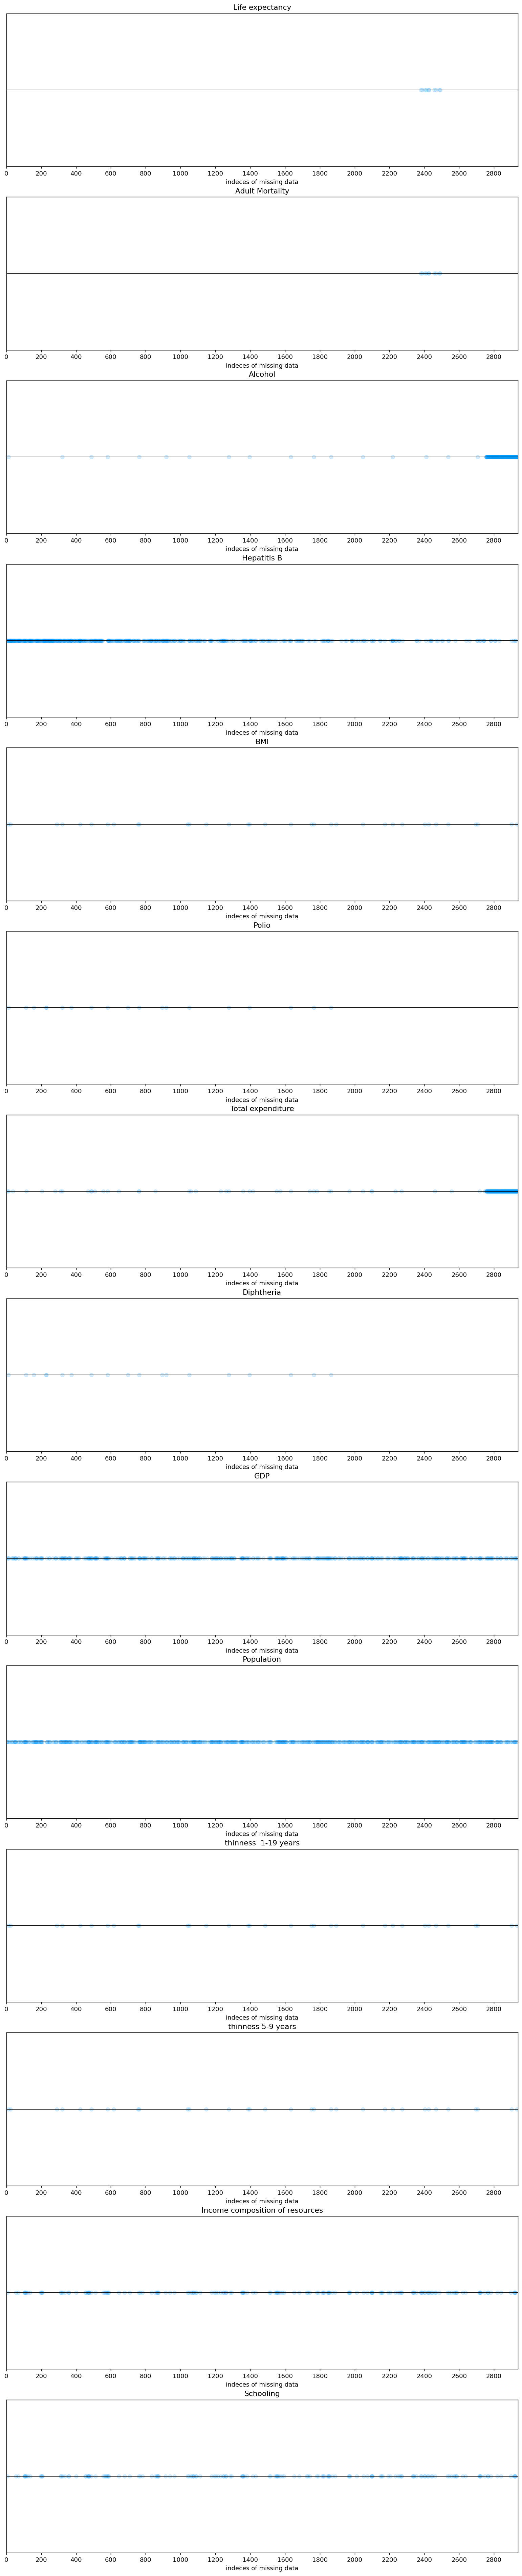

In [7]:
columns_with_null_values = regression_df.columns[(regression_df.isnull().sum()>0).values]
column_and_indeces = {}

for column in columns_with_null_values:
    column_and_indeces[column] = regression_df[regression_df[column].isnull()==True].index

fig, axes = plt.subplots(len(column_and_indeces), figsize = (15, 75), dpi = 130)
xmin = 0
xmax = 2938


for index, (key, values) in enumerate(column_and_indeces.items()):
    axes[index].hlines(y=0, xmin=xmin, xmax=xmax, color='black', linewidth=1)

    axes[index].scatter(values, [0] * len(values), color=(0,0.6,1), alpha=0.15)

    axes[index].set_yticks([])
    axes[index].set_xticks(np.arange(xmin, xmax, 200))

    axes[index].set_xlim(0, 2938)
    axes[index].set_ylim(-1, 1)

    axes[index].set_title(key)
    axes[index].set_xlabel("indeces of missing data")


In [ ]:
metrics_with_weird_behavior = [
    'Alcohol',
    'BMI',
    'Polio',
    'Total expenditure',
    'Diphtheria',
    'thinness  1-19 years',
    'thinness 5-9 years',
]

countries_total_missing_values = {}


for metric in metrics_with_weird_behavior:
    df = pd.DataFrame(regression_df[regression_df[metric].isnull()==True]['Country'].value_counts())

    for item in df.iterrows():
        if item[0] in countries_total_missing_values.keys():
            countries_total_missing_values[item[0]]+=item[1].values[0]
        else:
            countries_total_missing_values[item[0]] = item[1].values[0]


pd.DataFrame(
                {
                    'Country': countries_total_missing_values.keys(),
                    'Total_Null': countries_total_missing_values.values()
                }             
             ).sort_values(by='Total_Null', ascending=False)[:15]

,Country,Total_Null
0,South Sudan,99
62,Sudan,50
67,Somalia,17
50,Democratic People's Republic of Korea,17
1,Montenegro,15
42,Timor-Leste,6
171,Iraq,5
178,Monaco,3
179,San Marino,3
124,Argentina,2


**<h3>**We can see, that South Sudan and Sudan miss lots of data, so it'd be reasonable to drop the data instances from South Sudan & Sudan**</h3>**

In [ ]:
regression_df = regression_df[regression_df['Country']!='South Sudan']
regression_df = regression_df[regression_df['Country']!='Sudan']

regression_df.reset_index(drop=True, inplace=True)


**<h3>**As the other indices of missing data are distributed rather randomly we can omit the step with analyzing them as it is pretty safe to say that the reason for the absence of some metrics is random**</h3>**

In [ ]:
regression_df_wo_null = regression_df.copy()
regression_df_wo_null = regression_df_wo_null.dropna()

<Axes: >

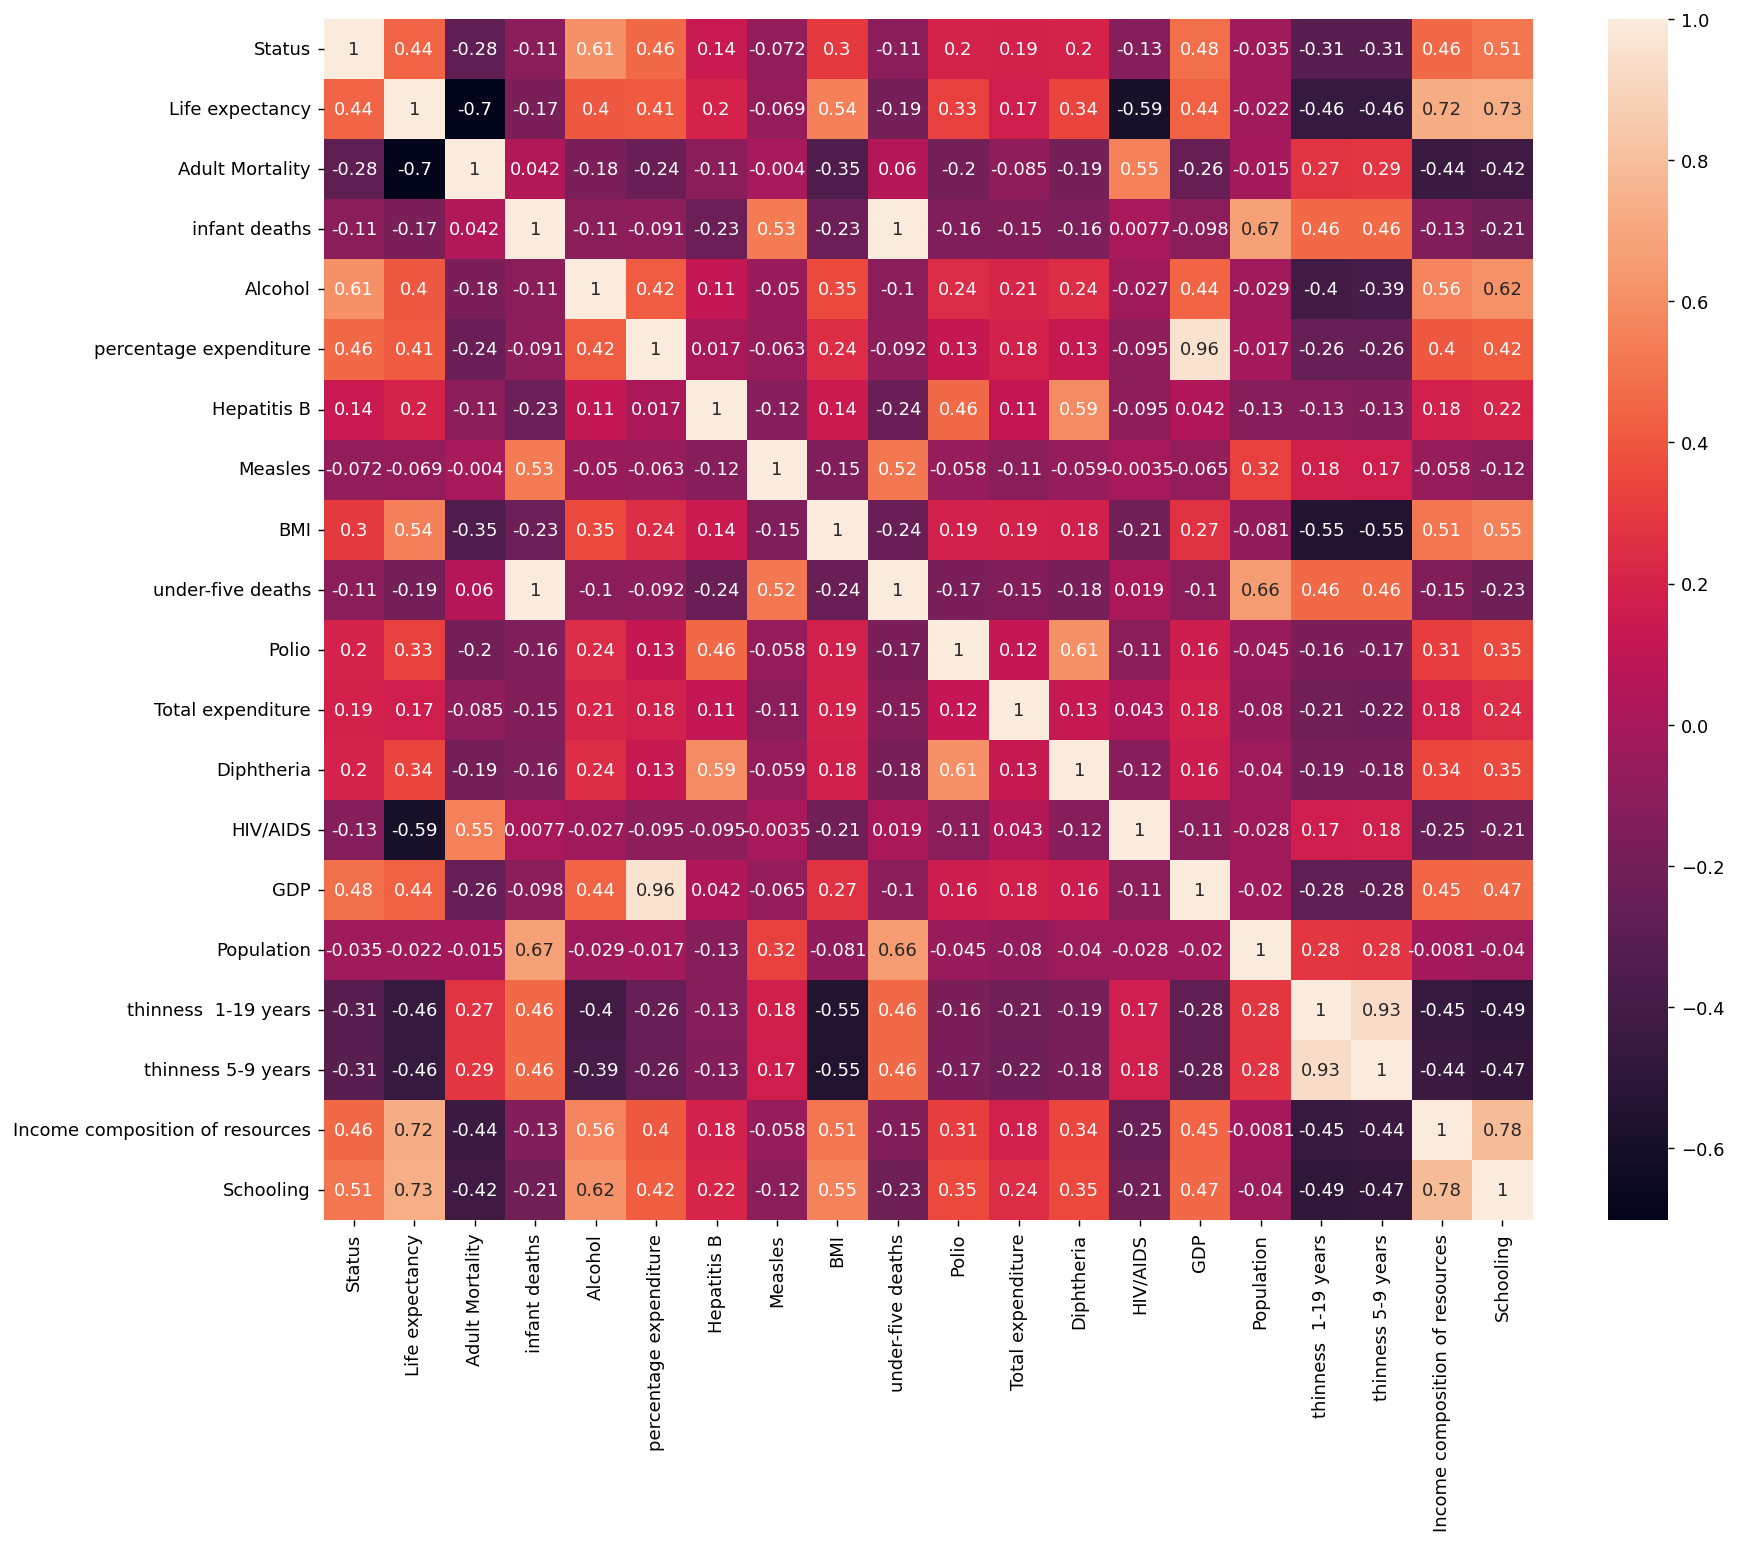

In [ ]:
fig, ax = plt.subplots(figsize = (15,12), dpi=130)


heatmap(regression_df_wo_null[regression_df_wo_null.columns[2:]].corr(), annot=True, ax=ax)

**<h3>**Principal Component Analysis**</h3>**

In [ ]:
for column in regression_df_wo_null.columns[2:]:
    x = regression_df_wo_null[column]
    regression_df_wo_null[column] = (x-x.mean())/x.std(ddof=1)

regression_df_wo_null_features = regression_df_wo_null[regression_df_wo_null.columns[2:]]



pca = PCA(n_components = len(regression_df_wo_null_features.columns))
pca.fit(regression_df_wo_null_features)
sliced_regression_df_wo_null = pca.transform(regression_df_wo_null_features)



importance = np.abs(pca.components_) * pca.explained_variance_ratio_.reshape(-1, 1)
feature_importance = importance.sum(axis=0)

for col_name, importance in zip(regression_df.columns[2:], feature_importance):
    print(col_name, '-', importance)

Status - 0.19699322427835575
Life expectancy - 0.18855691788539491
Adult Mortality - 0.19624449716165712
infant deaths - 0.16494114754591033
Alcohol - 0.2048670708835029
percentage expenditure - 0.19701900284680787
Hepatitis B - 0.16712813971883458
Measles - 0.17713064270794168
BMI - 0.17782070970918817
under-five deaths - 0.1648707607170684
Polio - 0.16957025106823598
Total expenditure - 0.13740426186624424
Diphtheria - 0.16127733936491798
HIV/AIDS - 0.18269190596743043
GDP - 0.1996752925756845
Population - 0.16762942983857124
thinness  1-19 years - 0.2045261590103707
thinness 5-9 years - 0.2033316434165947
Income composition of resources - 0.1825564955975875
Schooling - 0.1757081584800218


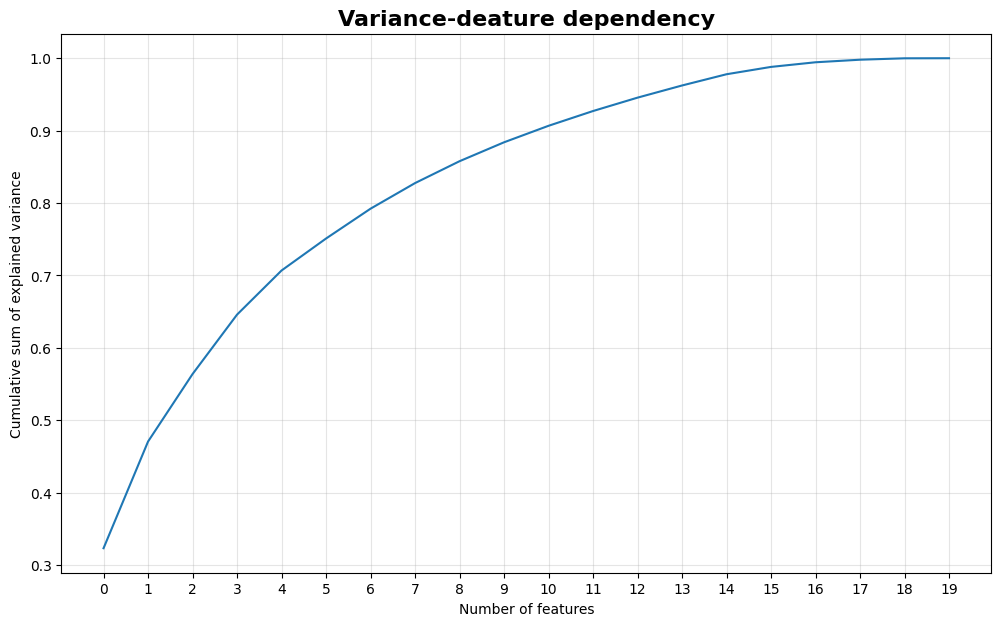

In [ ]:
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumsum_variance)
plt.grid(alpha=.33)
plt.xticks(np.arange(len(regression_df_wo_null_features.columns)))
plt.ylabel('Cumulative sum of explained variance')
plt.xlabel('Number of features')
plt.title('Variance-deature dependency', fontdict={'fontsize': 16, 'weight': 'bold'})
plt.show()

**<h3>**With the help of correlation matrix and PCA we can say that there are a couple of features that highly correlated with other features, which is not good from statistical point of view, so we're going to remove certain features from the dataset**</h3>**

**<h3>**We also saw that all the features contribte to the target variable relatively the same**</h3>**

**<h4>**I'll leave this problem of filling NA values for future as I've got some ideas, but do not have enough time**</h4>**



In [ ]:
regression_df = regression_df.dropna().reset_index(drop=True)
regression_df = regression_df.drop(['Country', 'under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)
num_of_observations_per_year = regression_df.groupby('Year')['Life expectancy'].count()
num_of_observations_per_year

Year
2000     61
2001     66
2002     81
2003     95
2004    103
2005    110
2006    114
2007    120
2008    123
2009    126
2010    128
2011    130
2012    129
2013    130
2014    131
2015      2
Name: Life expectancy, dtype: int64

**<h3>**From the series above we can see that aftrer filtering out null data we have only certain years we can use for regression models because some of the years do not contain enough data**<h3>**

In [ ]:
relevant_years = num_of_observations_per_year[num_of_observations_per_year>100].index
regression_df = regression_df[regression_df['Year'].isin(relevant_years)]

regression_dfs_by_year = {year: df for year, df in regression_df.groupby('Year')}

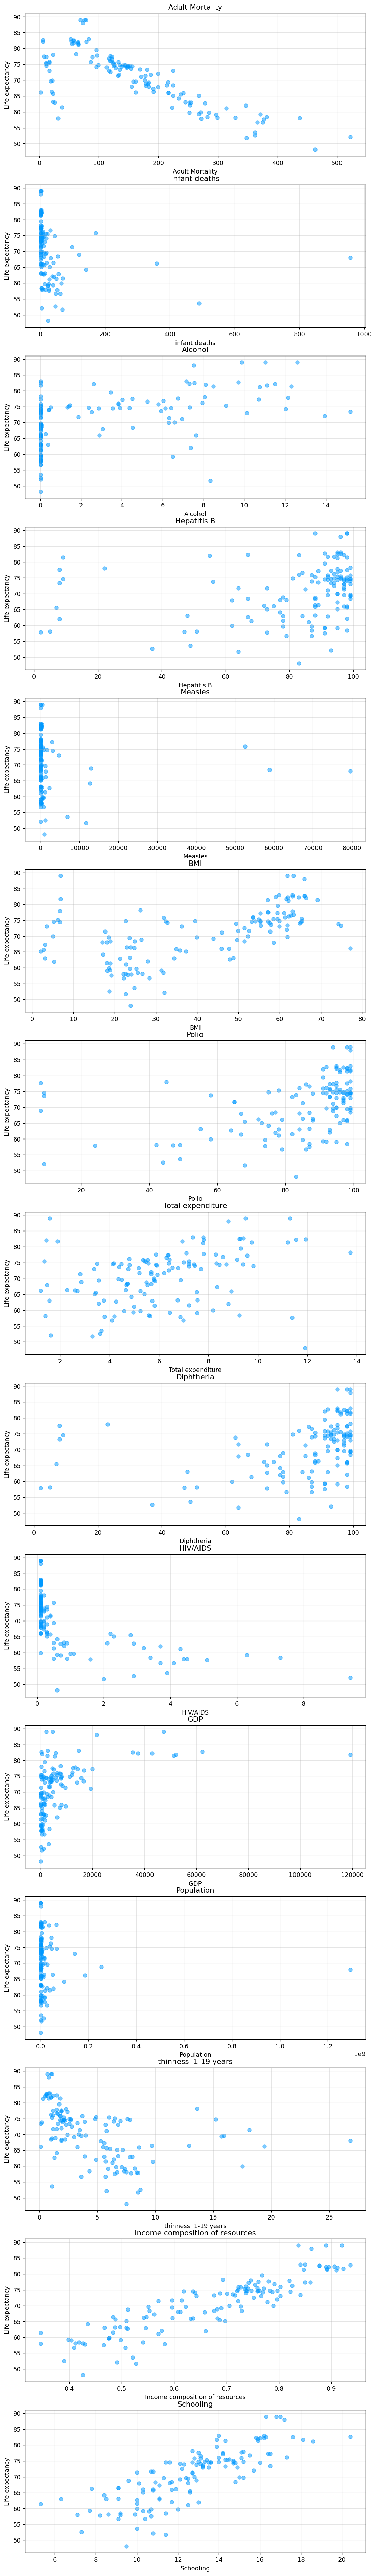

In [ ]:
regression_dfs_by_year[2014]

fig, axes = plt.subplots(len(regression_dfs_by_year[2014].columns[3:]), figsize=(10, 75), dpi=130)


for col_num, col_name in enumerate(regression_dfs_by_year[2014].columns[3:]):

    axes[col_num].scatter(regression_dfs_by_year[2014][col_name], regression_dfs_by_year[2014]['Life expectancy'], alpha=0.5, color=(0,0.6,1))
    axes[col_num].set_title(col_name)
    axes[col_num].set_xlabel(col_name)
    axes[col_num].set_ylabel('Life expectancy')
    axes[col_num].grid(alpha=0.33)



**<h3>**Importing model for regression task:**</h3>**
<h5>1. statsmodels' Linear Regression<br></h5>

In [ ]:
from statsmodels.api import OLS

linreg_results = {}

for year, df in regression_dfs_by_year.items():
    feature_matrix = df[df.columns[3:]]
    target = df['Life expectancy']

    linreg_statsmodels = OLS(target, feature_matrix).fit()
    linreg_results[year] = linreg_statsmodels

In [ ]:
for year in linreg_results.keys():
    print(f'for {year} R^2 value is {linreg_results[year].rsquared}')

for 2004 R^2 value is 0.9899659248892846
for 2005 R^2 value is 0.9895436973527428
for 2006 R^2 value is 0.9914681907465835
for 2007 R^2 value is 0.9922855311519831
for 2008 R^2 value is 0.9916971040549516
for 2009 R^2 value is 0.9900107553660685
for 2010 R^2 value is 0.9918144957113778
for 2011 R^2 value is 0.9937771253497604
for 2012 R^2 value is 0.9931956421819441
for 2013 R^2 value is 0.9937179892205342
for 2014 R^2 value is 0.9937622686800849


In [ ]:
linreg_results[2014].pvalues[linreg_results[2014].pvalues<0.05]

for year in linreg_results.keys():
    print(f'for {year} relevant feature are: \n\n{linreg_results[year].pvalues[linreg_results[year].pvalues<0.05]}')
    print('-'*37)
    print('\n\n\n')

for 2004 relevant feature are: 

Alcohol                 9.134344e-05
BMI                     1.343762e-03
Total expenditure       6.086519e-04
Diphtheria              1.513337e-02
HIV/AIDS                9.448658e-06
thinness  1-19 years    1.183987e-04
Schooling               2.034314e-12
dtype: float64
-------------------------------------




for 2005 relevant feature are: 

Alcohol                 8.650090e-05
Hepatitis B             3.662575e-02
Polio                   2.328433e-02
Total expenditure       3.325235e-02
HIV/AIDS                5.159106e-05
GDP                     4.494985e-02
thinness  1-19 years    2.032318e-03
Schooling               1.848295e-13
dtype: float64
-------------------------------------




for 2006 relevant feature are: 

Alcohol                            0.000503
Total expenditure                  0.003274
HIV/AIDS                           0.000792
thinness  1-19 years               0.000177
Income composition of resources    0.000019
Schooling   

**<h3>**Solving time series task**<h3>**

In [ ]:
tsa_df = df.copy()
tsa_df = tsa_df.sort_values(by=['Country', 'Year'])
tsa_df = tsa_df.dropna().reset_index(drop=True)
tsa_df = tsa_df.drop(['under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)
num_of_observations_per_country = tsa_df.groupby('Country')['Life expectancy'].count()
relevant_countries = num_of_observations_per_country[num_of_observations_per_country.sort_values(ascending=True)>10]

KeyError: 'Country'

In [ ]:
tsa_dfs_by_country = {year: df for year, df in df.groupby('Country')}

**<h5>**We can see that some of the columns contain null values, thus let us analyze it throughly, so we can think about how we'll handle them**<h5>**

**<h3>**Attempt to handle missing values via cosine similarity**<h3>**

In [ ]:
from numpy import dot
from numpy.linalg import norm   

def cos_similarity(a: tuple | list, b: tuple | list) -> np.float64:
    
    return dot(a, b)/(norm(a)*norm(b))

df["feature_vector"] = df[numerical_columns].apply(lambda row: tuple(row.fillna(0)), axis=1)


instances_with_null_values = []

for row_num, row in df.isnull().iterrows():
    if True in row.values:
        instances_with_null_values.append(row_num)

instances_with_null_values[:5]

row_for_row = {}

for row_num in instances_with_null_values:
    similarities = []
    for another_row in df.index[df.index!=row_num]:

        similarity = cos_similarity(df["feature_vector"][row_num], df["feature_vector"][another_row])
        similarities.append(similarity)
        # if similarity>list(max_similarity.values())[0]:
        #     max_similarity[another_row]=similarity
    row_for_row[row_num] = similarities

    

    

[32, 44, 45, 46, 47]

In [ ]:
df[df['infant deaths']==df['infant deaths'].max()]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1200,India,2001,Developing,62.9,222.0,1800,1.00,19.003406,NaN,51780,11.8,2400,58.0,4.50,59.0,0.3,447.138966,171477855.0,27.5,28.5,0.494,8.3
1201,India,2000,Developing,62.5,224.0,1800,0.93,19.266157,NaN,38835,11.4,2500,57.0,4.26,58.0,0.3,438.864634,1535912.0,27.7,28.6,0.489,8.3


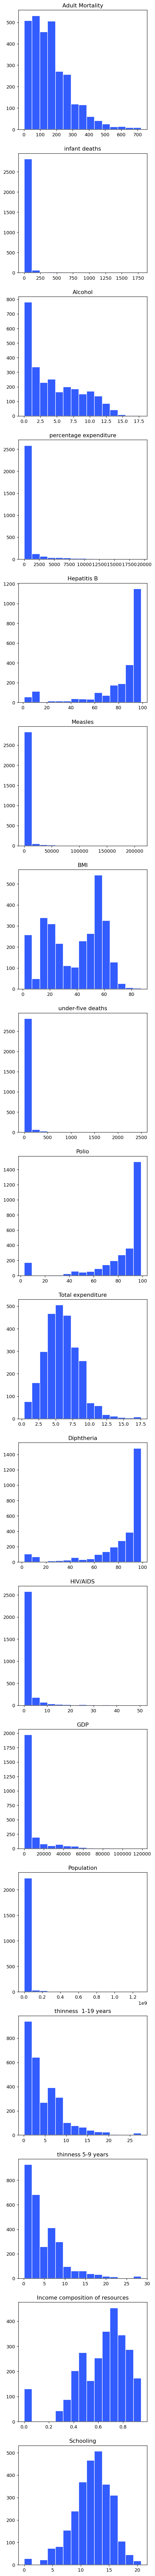

In [ ]:
fig, axes = plt.subplots(len(numerical_columns), figsize = (5, 100), dpi = 130)


for col_num, col_name in enumerate(numerical_columns):
    axes[col_num].hist(df[col_name], bins = 15, color = (0, 0.2, 1, 0.8), edgecolor='white')
    axes[col_num].set_title(f"{col_name}")

**USA BMI has false information, to be specific, in 2000 and 2001**

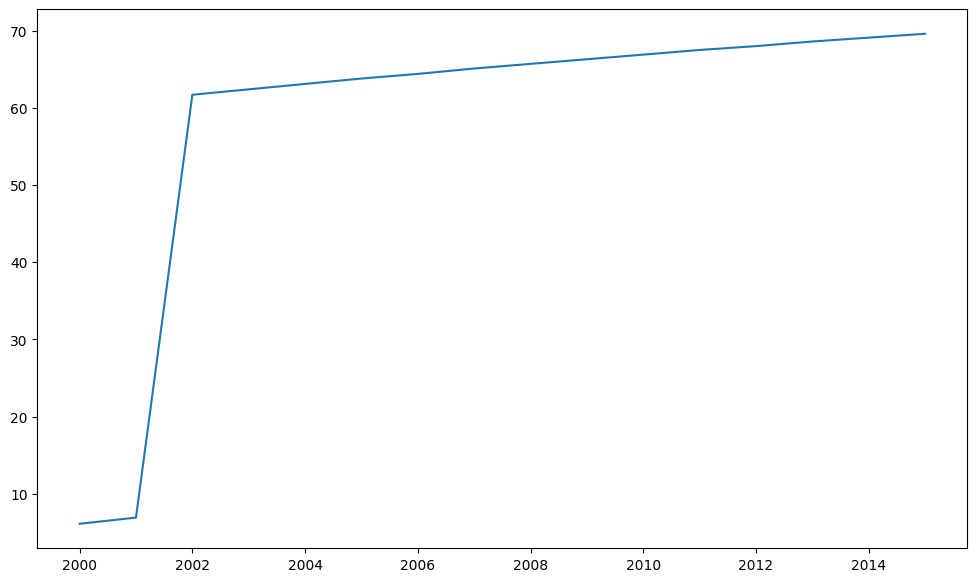

In [ ]:
year = df[df['Country']=='United States of America'].sort_values(by='Year', ascending=True)['Year']

bmi = df[df['Country']=='United States of America'].sort_values(by='Year', ascending=True)['BMI']


plt.plot(year, bmi)

In [ ]:
df.sort_values(by='BMI')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2887,Viet Nam,2002,Developing,73.8,137.0,30,2.03,0.000000,NaN,6755,1.0,39,92.0,4.70,75.0,0.2,NaN,NaN,15.6,16.3,0.584,10.7
2886,Viet Nam,2003,Developing,74.0,137.0,30,2.19,0.000000,78.0,2297,1.4,37,96.0,4.84,99.0,0.2,NaN,NaN,15.6,16.2,0.592,10.9
207,Bangladesh,2000,Developing,65.3,173.0,231,0.01,3.696331,NaN,5098,1.4,316,83.0,2.33,82.0,0.1,45.633710,131581243.0,2.9,21.5,0.459,7.3
206,Bangladesh,2001,Developing,65.8,168.0,219,0.01,3.395070,NaN,4414,1.8,298,85.0,2.47,85.0,0.1,42.598115,1341716.0,2.7,21.3,0.468,7.5
2885,Viet Nam,2004,Developing,74.2,136.0,29,2.86,0.000000,94.0,217,1.9,36,96.0,5.90,96.0,0.2,NaN,NaN,15.4,16.1,0.601,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,Sudan,2004,Developing,59.7,278.0,68,1.59,37.044800,NaN,9562,NaN,102,74.0,3.39,74.0,0.2,565.569459,3186341.0,NaN,NaN,0.415,5.7
2469,Sudan,2003,Developing,59.6,278.0,69,1.74,35.352647,NaN,4381,NaN,104,69.0,3.18,69.0,0.2,477.738478,29435944.0,NaN,NaN,0.409,5.6
2470,Sudan,2002,Developing,59.4,277.0,70,1.59,30.622875,NaN,4529,NaN,106,6.0,2.95,6.0,0.2,412.151756,28679565.0,NaN,NaN,0.403,5.6
2471,Sudan,2001,Developing,58.9,283.0,71,1.81,28.880697,NaN,4362,NaN,108,66.0,2.96,66.0,0.2,377.525445,279455.0,NaN,NaN,0.399,5.6


In [ ]:
df.iloc[2471]['BMI']

nan

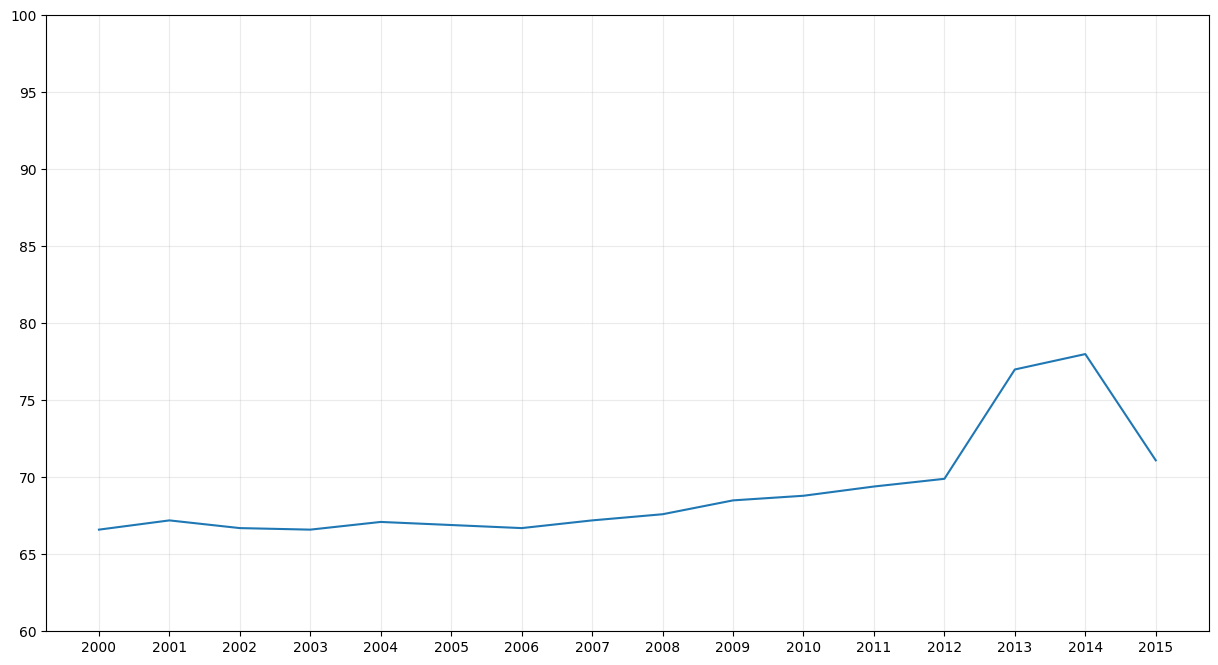

In [ ]:
fig, ax = plt.subplots(figsize = (15,8), dpi = 100)


ax.plot(
    df[df['Country']=='Kyrgyzstan']['Year'],
    df[df['Country']=='Kyrgyzstan']['Life expectancy']
    )
ax.grid(alpha=0.25)
ax.set_ylim([60, 100])
ax.set_xticks(np.arange(2000, 2016, 1))
plt.show()

<Axes: >

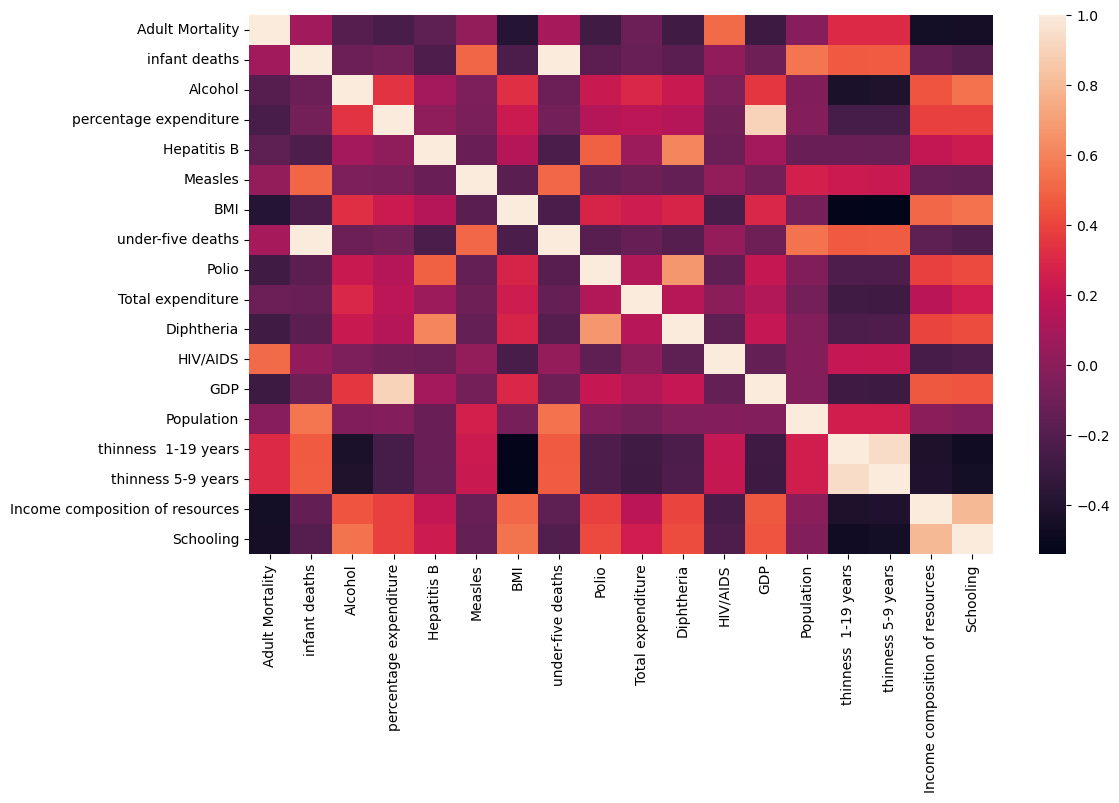

In [ ]:
heatmap(df[numerical_columns].corr())